In [148]:
import random
from queue import Queue
import matplotlib.pyplot as plt
import numpy as np
import math

In [149]:
class point:

    def __init__(self, x, y, data):
        #point data
        self.x = x
        self.y = y
        self.data = data

    def __repr__(self):
        return f'{{"x": {self.x}, "y": {self.y}}}'

In [150]:
class square:

    def __init__(self, x, y, l):
        # square cell initializing
        self.x = x
        self.y = y
        self.l = l
        self.points = []

    def __repr__(self):
        return f'({self.x}, {self.y}, {self.l})'

    def contains(self, point):
        # checks if point falls within a cell
        xcheck = self.x - (self.l / 2) <= point.x and self.x + (self.l / 2) >= point.x
        ycheck = self.y - (self.l / 2) <= point.y and self.y + (self.l / 2) >= point.y
        return xcheck and ycheck

In [151]:
class quadtree:

    def __init__(self, square, capacity, divided=False):
        #initialize quadtree object
        self.square = square
        self.capacity = capacity
        self.divided = divided
        self.topleft = None
        self.topright = None
        self.botleft = None
        self.botright = None

    def subdivide(self):
        #divide up the current cell
        x, y, l = self.square.x, self.square.y, self.square.l

        topleft = square(x-l/4, y+l/4, l/2)
        self.topleft = quadtree(topleft, 1)

        topright = square(x+l/4, y+l/4, l/2)
        self.topright = quadtree(topright, 1)

        botleft = square(x-l/4, y-l/4, l/2)
        self.botleft = quadtree(botleft, 1)

        botright = square(x+l/4, y-l/4, l/2)
        self.botright = quadtree(botright, 1)

        self.divided = True

        for point in self.square.points:
            self.topleft.insert(point)
            self.topright.insert(point)
            self.botleft.insert(point)
            self.botright.insert(point)

        self.square.points = []

    def insert(self, point):
        #insert a point into the quadtree
        if not self.square.contains(point):
            return False
        elif self.divided:
            result = self.topleft.insert(point)
            if not result:
                result = result or self.topright.insert(point)
            if not result:
                result = result or self.botleft.insert(point)
            if not result:
                result = result or self.botright.insert(point)
            return True
        elif len(self.square.points) < self.capacity:
            self.square.points.append(point)
            return True
        else:
            self.subdivide()
            result = self.topleft.insert(point)
            if not result:
                result = result or self.topright.insert(point)
            if not result:
                result = result or self.botleft.insert(point)
            if not result:
                result = result or self.botright.insert(point)
            return True

    def killemptychildren(self):
        #get rid of any cells that do not have points inisde
        if not self.divided and len(self.square.points) != 0:
            return

        if not self.topleft.divided and len(self.topleft.square.points) == 0:
            self.topleft = None
        else:
            self.topleft.killemptychildren()
        
        if not self.topright.divided and len(self.topright.square.points) == 0:
            self.topright = None
        else:
            self.topright.killemptychildren()

        if not self.botleft.divided and len(self.botleft.square.points) == 0:
            self.botleft = None
        else:
            self.botleft.killemptychildren()

        if not self.botright.divided and len(self.botright.square.points) == 0:
            self.botright = None
        else:
            self.botright.killemptychildren()

        

    def printsub(self):
        if self.divided is False and len(self.square.points) > 0:
            print(self.square)
            print(self.square.points)
        else:
            if self.topleft is not None:
                self.topleft.printsub()
            if self.topright is not None:
                self.topright.printsub()
            if self.botleft is not None:
                self.botleft.printsub()
            if self.botright is not None:
                self.botright.printsub()

    def getlistofpoints(self, lst):
        #gets list of points from a tree
        #input list in form of [[xcoords], [ycoords], [distribution]
        #colors are hard coded to work with 2 distributinos
        if self.divided is False and len(self.square.points) > 0:
            lst[0].append(self.square.points[0].x)
            lst[1].append(self.square.points[0].y)
            if min(self.square.points[0].data) > 0:
                lst[2].append(2)
            elif self.square.points[0].data[0] > 0:
                lst[2].append(0)
            elif self.square.points[0].data[1] > 0:
                lst[2].append(1)
            else:
                lst[2].append(1000)

            return lst
        if self.topleft is not None:
            lst = self.topleft.getlistofpoints(lst)
        if self.topright is not None:
            lst = self.topright.getlistofpoints(lst)
        if self.botleft is not None:
            lst = self.botleft.getlistofpoints(lst)
        if self.botright is not None:
            lst = self.botright.getlistofpoints(lst)
        
        return lst
    
    def getcellboundaries(self, lst):
        #returns info wiht correct format to print the line segments of the cells
        #format is list of lists [[[x1, x2],[x3,x4]],[[y1, y2],[y3,y4]]]
        
        
        line1x = [self.square.x - self.square.l / 2, self.square.x - self.square.l / 2]
        line1y = [self.square.y - self.square.l / 2, self.square.y + self.square.l / 2]
        lst[0].append(line1x)
        lst[1].append(line1y)

        line2x = [self.square.x - self.square.l / 2, self.square.x + self.square.l / 2]
        line2y = [self.square.y + self.square.l / 2, self.square.y + self.square.l / 2]
        lst[0].append(line2x)
        lst[1].append(line2y)

        line3x = [self.square.x + self.square.l / 2, self.square.x + self.square.l / 2]
        line3y = [self.square.y + self.square.l / 2, self.square.y - self.square.l / 2]
        lst[0].append(line3x)
        lst[1].append(line3y)

        line4x = [self.square.x - self.square.l / 2, self.square.x + self.square.l / 2]
        line4y = [self.square.y - self.square.l / 2, self.square.y - self.square.l / 2]
        lst[0].append(line4x)
        lst[1].append(line4y)

            
        
        if self.topleft is not None:
            lst = self.topleft.getcellboundaries(lst)
        if self.topright is not None:
            lst = self.topright.getcellboundaries(lst)
        if self.botleft is not None:
            lst = self.botleft.getcellboundaries(lst)
        if self.botright is not None:
            lst = self.botright.getcellboundaries(lst)

        return lst
    
    def plottree(self):
        #plots a quadtree, colors are hard coded for 2 distributions
        lstofpts = self.getlistofpoints([[],[],[]])

        qtreeboundaries = self.getcellboundaries([[],[]])

        for i in range(len(qtreeboundaries[0])):
            print("test")
            plt.plot(qtreeboundaries[0][i], qtreeboundaries[1][i], color="black")

        upperx = (self.square.x + self.square.l / 2) + .2 * abs(self.square.x + self.square.l / 2)
        uppery = (self.square.y + self.square.l / 2) + .2 * abs(self.square.y + self.square.l / 2)

        lowerx = (self.square.x - self.square.l / 2) - .2 * abs(self.square.x - self.square.l / 2)
        lowery = (self.square.y - self.square.l / 2) - .2 * abs(self.square.y - self.square.l / 2)
        dist1 = [[],[]]
        dist2 = [[],[]]
        bothdist = [[],[]]
        print(lstofpts)
        for i in range(len(lstofpts[0])):
            if lstofpts[2][i] == 0:
                dist1[0].append(lstofpts[0][i])
                dist1[1].append(lstofpts[1][i])
            elif lstofpts[2][i] == 1:
                dist2[0].append(lstofpts[0][i])
                dist2[1].append(lstofpts[1][i])
            else:
                bothdist[0].append(lstofpts[0][i])
                bothdist[1].append(lstofpts[1][i])
        plt.plot(dist1[0], dist1[1], 'ro', color="red")
        plt.plot(dist2[0], dist2[1], 'ro', color="blue")
        plt.plot(bothdist[0], bothdist[1], 'ro', color="purple")
        plt.axis((lowerx, upperx, lowery, uppery))
        plt.show()

In [152]:
def getrandshift(lstofpts):
    #constructs the initial square for a random shift quadtree
    initx, inity, initlength = getboundingbox(lstofpts)
    minx = initx - initlength/2
    maxx = initx + initlength/2
    miny = inity - initlength/2
    maxy = inity + initlength/2

    shiftx = np.random.uniform(minx, maxx)
    shifty = np.random.uniform(miny, maxy)

    newlength = initlength*2
    
    return shiftx, shifty, newlength

In [153]:
def is_leaf(qtree):
    if qtree.divided == False:
        return True
    else:
        return False


In [154]:
cost = 0
transport_plan = {}

In [155]:
def compute_ot(qtree, cost_func):
    global cost
    global transport_plan

    if qtree == None:
        return []

    if is_leaf(qtree): # base case: leaf node
        p = qtree.square.points[0] # there should only be one point 
        val = min(p.data)
        if val > 0: # if both distributions have mass at same point
            transport_plan[(p.x, p.y)] = [((p.x, p.y), val)]
            p.data[0] -= val
            p.data[1] -= val
        if max(p.data) > 0: # if there is still mass at point push up
            return qtree.square.points
        else: return []
    #recursive call
    qtree.square.points = (compute_ot(qtree.topleft, cost_func) + compute_ot(qtree.topright, cost_func)
                         + compute_ot(qtree.botleft, cost_func) + compute_ot(qtree.botright, cost_func))
    if qtree.square.points == []:
        return []
    mass = [0, 0] #only two distributions
    dist1_q = Queue()
    dist2_q = Queue()
    for p in qtree.square.points:
        mass[0] += p.data[0]
        mass[1] += p.data[1]
        if p.data[0] > 0:
            dist1_q.put(p)
        else:                    # each point now should only have mass from one distribution after           
            dist2_q.put(p)       # pairing at leaf nodes
    
    val = min(mass)

    while val > 0.00000000000001:
        while dist1_q.empty() == False and dist2_q.empty() == False:
            p1 = dist1_q.get()
            p2 = dist2_q.get()
            massmatch = min(p1.data[0], p2.data[1])
            val -= massmatch
            p1.data[0] -= massmatch
            p2.data[1] -= massmatch
            if (p1.x, p1.y) not in transport_plan:
                transport_plan[(p1.x, p1.y)] = []
            transport_plan[(p1.x, p1.y)].append(((p2.x, p2.y), massmatch))
            cost += cost_func(p1, p2) * massmatch
            if p1.data[0] > 0.00000000000001:
                dist1_q.put(p1)
            if p2.data[1] > 0.00000000000001:
                dist2_q.put(p2)


        # p1 = dist1_q.get()
        # if (p1.x, p1.y) not in transport_plan:
        #     transport_plan[(p1.x, p1.y)] = []
        # if p1.data[0] > val:   # map all points from dist2 
        #     while dist2_q.empty() == False:
        #         p2 = dist2_q.get()
        #         transport_plan[(p1.x, p1.y)].append(((p2.x, p2.y), p2.data[1]))
        #         cost += cost_func(p1, p2) * p2.data[1]
        #         p2.data[1] = 0
        #     p1.data[0] -= val
        #     val = 0

        # else:   # p1.data[0] <= val
        #     m = p1.data[0]
        #     while m > 0.00000000000001:
        #         p2 = dist2_q.get()
        #         if m >= p2.data[1]:
        #             m -= p2.data[1]
        #             val -= p2.data[1]
        #             transport_plan[(p1.x, p1.y)].append(((p2.x, p2.y), p2.data[1]))
        #             cost += cost_func(p1, p2) * p2.data[1]
        #             p1.data[0] -= p2.data[1]
        #             p2.data[1] = 0
        #         else:   # m < p2.data[1]
        #             val -= m
        #             transport_plan[(p1.x, p1.y)].append(((p2.x, p2.y), m))
        #             cost += cost_func(p1, p2) * m
        #             p1.data[0] = 0
        #             p2.data[1] -= m
        #             dist2_q.put(p2)
        #             m = 0
    
    return [p for p in qtree.square.points if max(p.data) > 0.00000000000001]

In [156]:
def euclid_dist(a, b):
    return math.sqrt((b.x-a.x)**2 + (b.y-a.y)**2)

In [157]:
#test with 2 distributions with one point each

cost = 0
transport_plan = {}

sq = square(0, 0, 3)
qtree = quadtree(sq, 1)
qtree.insert(point(1, 0, [1, 0]))
qtree.insert(point(0, 0, [0, 1]))
qtree.killemptychildren()
#qtree.printsub()

print(compute_ot(qtree, euclid_dist))

print(cost)
print(transport_plan)

[]
1.0
{(1, 0): [((0, 0), 1)]}


In [158]:
def getboundingbox(lstofpts):
    minx = float('inf')
    maxx = -float('inf')
    miny = float('inf')
    maxy = -float('inf')

    for pt in lstofpts:
        if pt.x < minx:
            minx = pt.x
        if pt.x > maxx:
            maxx = pt.x
        if pt.y < miny:
            miny = pt.y
        if pt.y > maxy:
            maxy = pt.y


    centerx = (minx + maxx)/2
    centery = (miny + maxy)/2
    length = max(maxx-minx, maxy-miny)
    
    return centerx, centery, length

In [159]:
def trunc(values, decs=0):
    return np.trunc(values*10**decs)/(10**decs)

def normalize_image(im):
    s = np.sum(im)
    normalized_im = im/s
    return normalized_im

In [173]:
def images_to_points(im1, im2):
    points = []
    m = max(im1.shape[0], im2.shape[0])
    n = max(im1.shape[1], im2.shape[1])
    for i in range(m):
        for j in range(n):
            if i < im1.shape[0] and j < im1.shape[1]:
                if i < im2.shape[0] and j < im2.shape[1]:
                    p = point(i, j, [im1[i][j], im2[i][j]])
                    points.append(p)
                else:
                    p = point(i, j, [im1[i][j], 0])
                    points.append(p)
            else:
                if i < im2.shape[0] and j < im2.shape[1]:
                    p = point(i, j, [0, im2[i][j]])
                    points.append(p)
    return points

In [161]:
def heatmapin(transport_plan, x, y):
    #plots heat map of the transport plan, lighter means higher cost coming into a point
    
    hm = [[0 for k in range(y)] for i in range(x)]

    for ptin, matchings in transport_plan.items():
        costin = 0
        for match in matchings:
            costin += math.sqrt((ptin[0]-match[0][0])**2 + (ptin[1]-match[0][1])**2) * match[1]
        hm[ptin[0]][ptin[1]] = costin
    
    plt.imshow(hm) 
    plt.colorbar()
    plt.title( "2-D Heat Map" ) 
    plt.show()

def heatmapout(transport_plan, x, y):
    #plots heat map of the transport plan, lighter means higher cost coming into a point
    
    hm = [[0 for k in range(y)] for i in range(x)]

    reverseMapping = {}
    for ptin, matchings in transport_plan.items():
        for match in matchings:
            if (match[0][0], match[0][1]) not in reverseMapping:
                reverseMapping[(match[0][0], match[0][1])] = 0
            reverseMapping[(match[0][0], match[0][1])] += math.sqrt((ptin[0]-match[0][0])**2 + (ptin[1]-match[0][1])**2) * match[1]
    
    for val in reverseMapping:
        hm[val[0]][val[1]] = reverseMapping[val]
    
    plt.imshow(hm) 
    plt.colorbar()
    plt.title( "2-D Heat Map" ) 
    plt.show()

In [162]:
#test on identical images

from PIL import Image

hand0 = np.array(Image.open("testing images/hand0.png")) #load image and get pixel values
identical_image_points = images_to_points(hand0, hand0)

cost = 0
transport_plan = {}
sq1_x, sq1_y, sq1_l = getboundingbox(identical_image_points)
sq1 = square(sq1_x, sq1_y, sq1_l)
qtree1 = quadtree(sq1, 1)
for p in identical_image_points:
    qtree1.insert(p)
#qtree1.plottree()
qtree1.killemptychildren()
print(cost)
#print(transport_plan)

0


1.2000332842527903
0


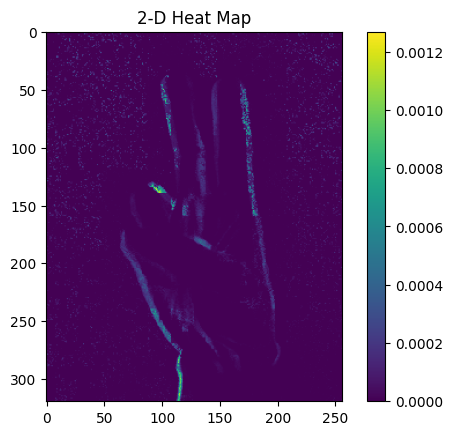

In [163]:
#test on very similar images

hand0 = np.array(Image.open("testing images/hand0.png")) #load image and get pixel values
hand1 = np.array(Image.open("testing images/hand1.png"))
normalized_hand0 = normalize_image(hand0)
normalized_hand1 = normalize_image(hand1)
similar_image_points = images_to_points(normalized_hand0, normalized_hand1)

cost = 0
transport_plan = {}
sq2_x, sq2_y, sq2_l = getboundingbox(similar_image_points)
sq2 = square(sq2_x, sq2_y, sq2_l)
qtree2 = quadtree(sq2, 1)
for p in similar_image_points:
    qtree2.insert(p)
qtree2.killemptychildren()
ret = compute_ot(qtree2, euclid_dist)
print(cost)
print(len(ret))

m, n = hand0.shape
heatmapin(transport_plan, m, n)

In [164]:
#test on different images

tree = Image.open("testing images/tree.png").convert('L')
dog = np.array(Image.open("testing images/dog.png"))
normalized_tree = normalize_image(tree)
normalized_dog = normalize_image(dog)
different_image_points = images_to_points(normalized_tree, normalized_dog)

cost = 0
transport_plan = {}
sq3_x, sq3_y, sq3_l = getboundingbox(different_image_points)
sq3 = square(sq3_x, sq3_y, sq3_l)
qtree3 = quadtree(sq3, 1)
for p in different_image_points:
    qtree3.insert(p)
qtree3.killemptychildren()

ret = compute_ot(qtree3, euclid_dist)
print(cost)
print(len(ret))


36.31627460141916
0


In [174]:
#test on different size images

different_size_image_points = images_to_points(normalized_hand0, normalized_dog)
cost = 0
transport_plan = {}
sq4_x, sq4_y, sq4_l = getboundingbox(different_size_image_points)
sq4 = square(sq4_x, sq4_y, sq4_l)
qtree4 = quadtree(sq4, 1)
for p in different_size_image_points:
    qtree4.insert(p)
qtree4.killemptychildren()

ret = compute_ot(qtree4, euclid_dist)
print(cost)
print(len(ret))

81920
81920
58.92721471337399
0
